Import 

In [1]:
import numpy as np
import random
from collections import OrderedDict
import matplotlib.pyplot as plt

Neural Network 모델 클래스

In [2]:
class Simple_Neural_Network:
    def __init__(self,weight_init_std=0.01):
        # 0.01을 곱해주는 이유: w초기값이크면 gradient vanishing 문제가 발생함.
        self.params={}
        self.params['W1']=weight_init_std*np.random.randn(3,4)
        self.params['B1']=np.zeros(4)
        self.params['W2']=weight_init_std*np.random.randn(4,4)
        self.params['B2']=np.zeros(4)
        self.params['W3']=weight_init_std*np.random.randn(4,3)
        self.params['B3']=np.zeros(3)
        
        # OrderedDict사용 이유: python의 일반적인 Dictionary는 key,Value 쌍이 추가되는 순서를 기억하지 않음. 
        # 순서가 달라도 같은 key,value값이 있으면 같다고 판단함
        # OrderedDict은 삽입된 순서를 기억하는 딕셔너리 자료형임. 순서까지 같아야 같다고 판단함.
        # self.layers=OrderedDict() 
        self.layers={} # 하지만 지금코드에선 이렇게 써도 무방.
        self.layers['Affine1']=Affine(self.params['W1'],self.params['B1']) 
        self.layers['Sigmoid1']=Sigmoid()
        self.layers['Affine2']=Affine(self.params['W2'],self.params['B2']) 
        self.layers['Sigmoid2']=Sigmoid()
        self.layers['Affine3']=Affine(self.params['W3'],self.params['B3']) 
        self.LastLayer=softmax_with_loss()
        
    def forward_pass(self,input):
        for layer in self.layers.values():
            input=layer.forward(input)

        return input
    
    def loss(self,input,t):
        last_input=self.forward_pass(input)
        return self.LastLayer.forward(last_input,t)
    
    def accuracy(self,input,t):
        y=self.forward_pass(input)
        y=np.argmax(y,axis=1) # y,t의 최대 인덱스
        t=np.argmax(t,axis=1)
        count=np.sum(y==t) # y와 t가 같은 것의 개수
        accuracy= count/ float(input.shape[0])
        return accuracy
    
    def gradient(self,input,t):
        self.loss(input,t) #순전파
        
        #역전파 시작
        dout=1
        dout=self.LastLayer.backward(dout)
        
        layers=list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout=layer.backward(dout)
            
        grad={}
        grad['W1']=self.layers['Affine1'].dW
        grad['B1']=self.layers['Affine1'].dB
        
        grad['W2']=self.layers['Affine2'].dW
        grad['B2']=self.layers['Affine2'].dB
        
        grad['W3']=self.layers['Affine3'].dW
        grad['B3']=self.layers['Affine3'].dB
        
        return grad


Affine 계층 클래스

In [3]:
class Affine:
    def __init__(self,W,B):
        self.W=W
        self.B=B
        self.X=None
        self.dW=None
        self.dB=None
    
    def forward(self,X):
        self.X=X
        out=np.dot(self.X, self.W)+self.B
        return out
    
    def backward(self,dout):
        dx=np.dot(dout,self.W.T)
        self.dW=np.dot(self.X.T,dout)
        self.dB=np.sum(dout,axis=0)
        return dx    


Sigmoid 계층 클래스

In [4]:
class Sigmoid:
    def __init__(self):
        self.out=None
        
    def forward(self,X):
        self.out=1/(1+np.exp(-X))
        return self.out
    
    def backward(self, dout):
        dx=dout*(1.0-self.out)*self.out
        return dx

Softmax 와 Loss Function(cross entropy)계층 클래스

In [5]:
class softmax_with_loss:
    def __init__(self):
        self.y=None
        self.loss=None
        self.t=None
        
    def forward(self,X,T):
        self.y=softmax_inbook(X) 
        self.t=T  
        self.loss=cross_entropy_error(self.t,self.y)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

Input Data 초기화 함수

In [6]:
def init_xt():
    input_data=np.empty((0,3))
    t=np.empty((0,3))
    for i in range(1100):
        input_data=np.append(input_data, np.array([[random.randrange(0,300) for j in range(3)]]),axis=0)
        x=input_data[-1,0]
        if x<100:
            t=np.append(t,np.array([[1, 0, 0]]),axis=0)
        elif x<200:
            t=np.append(t,np.array([[0, 1, 0]]),axis=0)
        elif x<300:
            t=np.append(t,np.array([[0, 0, 1]]),axis=0)
        # print(x)

    return input_data,t


Sigmoid 함수

In [7]:
def softmax(x):
    c=np.max(x)     # 오버플로 대책 딥러닝책 p.94
    exp_x=np.exp(x-c)
    sum_exp_x=np.sum(exp_x)
    y=exp_x/sum_exp_x
    return y

def softmax_inbook(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


Cross Entropy 함수

In [8]:
def cross_entropy_error(t,y):
    delta=1e-7  # np.log에 0을 넣으면  계산을 할 수 없음 log(0)은 무한대이므로
    
    batch_size=y.shape[0]
    return -np.sum(t*np.log(y+delta))/batch_size


Main 함수

주피터 노트북으로 간편히 코드 수정하기 위해 main 사용 안함.

In [9]:
# if __name__ == '__main__':

Input Data 세팅

In [10]:

XYZ,t=init_xt() #데이터, 정답 초기화

xyz_train_set=XYZ[0:1000,:]
t_train_set=t[0:1000,:]

xyz_test_set=XYZ[1000:1100,:]
t_test_set=t[1000:1100,:]

network=Simple_Neural_Network()


Hyper Parameter 세팅

In [11]:

# batch 나눠서 진행
iteration_num=30000
batch_size=100
learning_rate=0.01

train_loss_list=[]
train_acc_list=[]
test_acc_list=[]

iter_per_epoch=xyz_train_set.shape[0]/batch_size

Train 시작

In [12]:
for i in range(iteration_num):
    batch_mask=np.random.choice(xyz_train_set.shape[0],batch_size)  #랜덤으로 trian_set에서 뽑아옴
    xyz_batch=xyz_train_set[batch_mask]
    t_batch=t_train_set[batch_mask]
    
    grad=network.gradient(xyz_batch,t_batch)
    
    for key in ('W1','B1','W2','B2','W3','B3'): 
        network.params[key]-=learning_rate*grad[key] # SGD사용
        # print(network.params)

    
    loss=network.loss(xyz_batch,t_batch)
    train_loss_list.append(loss)
    
    if i%iter_per_epoch==0:
        train_acc=network.accuracy(xyz_train_set,t_train_set)
        test_acc=network.accuracy(xyz_test_set,t_test_set)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("Train Set Accuracy : ",train_acc,"\tTest Set Accuracy : ",test_acc)

Train Set Accuracy :  0.33 	Test Set Accuracy :  0.36
Train Set Accuracy :  0.33 	Test Set Accuracy :  0.36
Train Set Accuracy :  0.33 	Test Set Accuracy :  0.36
Train Set Accuracy :  0.33 	Test Set Accuracy :  0.36
Train Set Accuracy :  0.33 	Test Set Accuracy :  0.36
Train Set Accuracy :  0.355 	Test Set Accuracy :  0.28
Train Set Accuracy :  0.355 	Test Set Accuracy :  0.28
Train Set Accuracy :  0.355 	Test Set Accuracy :  0.28
Train Set Accuracy :  0.355 	Test Set Accuracy :  0.28
Train Set Accuracy :  0.355 	Test Set Accuracy :  0.28
Train Set Accuracy :  0.355 	Test Set Accuracy :  0.28
Train Set Accuracy :  0.355 	Test Set Accuracy :  0.28
Train Set Accuracy :  0.355 	Test Set Accuracy :  0.28
Train Set Accuracy :  0.355 	Test Set Accuracy :  0.28
Train Set Accuracy :  0.355 	Test Set Accuracy :  0.28
Train Set Accuracy :  0.355 	Test Set Accuracy :  0.28
Train Set Accuracy :  0.355 	Test Set Accuracy :  0.28
Train Set Accuracy :  0.355 	Test Set Accuracy :  0.28
Train Set Accur

Plot

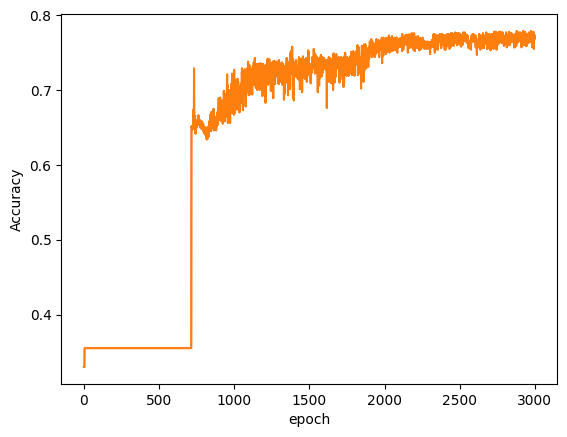

In [13]:
trian_plot = plt.plot(range(len(train_acc_list)),train_acc_list)
test_plot = plt.plot(range(len(train_acc_list)),train_acc_list)
plt.setp(trian_plot,color='r', linewidth=1.0)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()